# Bayesian Optimization

## 1. Background

Bayesian optimization is a powerful techinque for finding hyperparameters, $x$, that maximize or minimize, an objective function, $f$. For example, many machine learning techniques require tuning of hyperparameters such as learning rate, number of decision trees, number of clusters (k-means clustering), number of hidden layers in a deep neural network, etc. 

Intuitivetly, imagine you have an unknown function, $f(x)$, which value you're trying to optimize. Since you don't know the function, you're not able to solve it analytically by taking its first derivative. Instead you might want to simply sample values, $x$, until you find one that maximizes $f(x)$. But randomly searching for optimal paramaters can be very expensive computationally.

Bayesian optimization offers an alternative approach by setting a prior distribution over the unknown objective function and combining it with evidence to get a posterior distribution. In other words, having seen a few values for $f(x)$, what values of $x$ should we sample next? One way of doing it is by modelling the unknown function as a <b>Gaussian process (GP)</b> to obtain a prior distribution and update it according to an <b>aquisition function</b> that determines what values should be sampled next. 

This allows for a utility-based selection of the next observation to make on the objective function, which must take into account both exploration (sampling from areas of high uncertainty) and exploitation (sampling areas likely to offer improvement over the current best observation) (Brochu et al., 2010).

The basic algorithm then takes the following form:


In [ ]:
1: for t = 1, 2, . . . do
2:     Find xt by optimizing the acquisition function over the GP: xt = argmaxx u(x|D1:t−1).
3:     Sample the objective function: yt = f(xt) + εt.
4:     Augment the data D1:t = {D1:t−1, (xt, yt)} and update the GP.
5: end for

This procedure is repeated after a pre-specified number of iterations or after a convergance criteria has been met.

It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure.

There are a number of acquisition functions available including probability improvement, expected improvement, and upper confidence bound, which may differ at times. I'll show a few examples below using scikit learn, but for a detailed explanation read the following [paper](https://arxiv.org/pdf/1012.2599.pdf).

<img src="bayes_optim.png" height="600" width="500"/>
In the figure above, the top row represents the objective function you're trying to optimize as a GP, and the rows below are examples of different acquisition functions which are telling you where to sample next.

Note that we still need to optimize the acquisition function, so in a way we have traded an optimization problem for another, except that acquistion functions are well defined and thus easier to optimize.

For a more detailed discussion watch Nando deFreitas' lecture [here](https://www.youtube.com/watch?v=vz3D36VXefI&index=10&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&spfreload=1), and read the following [paper](https://arxiv.org/pdf/1012.2599.pdf).

## 2. 1-D Example

The following example uses Bayesian optimization to find the value of $x$ that maximizes a function $f$ using the Upper Confidence Bound (UCB) as the acquisition function.

UCB uses a free parameter $\kappa$ to control the balance between exploration and exploitation, and make it more or less conservative. Here we use $\kappa$ = 5.

This example uses the bayes_opt library by Fernando Nogueira found [here](https://github.com/fmfn/BayesianOptimization).

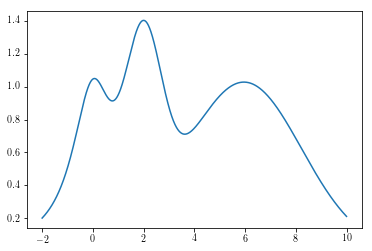

In [2]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# generate data from a target function
f = lambda x: np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = f(x)

plt.plot(x, y)


### Define Bayesian optimizer (UCB) and initialization parameters.

In [4]:
bo = BayesianOptimization(f, {'x': (-2, 10)})
bo.maximize(init_points=1, n_iter=0, acq='ucb', kappa=5)

def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(8, 5))
    fig.suptitle('t = {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '.', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.37389 |    2.1816 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


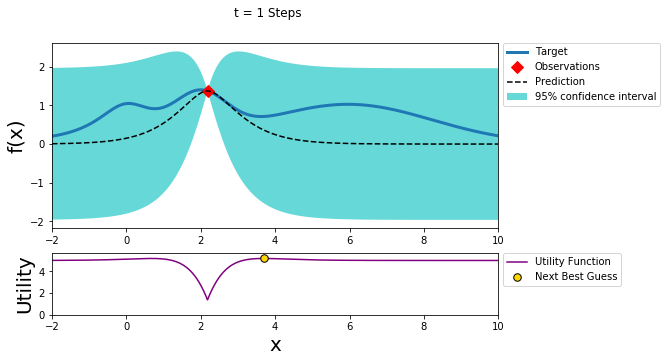

In [5]:
plot_gp(bo, x, y)

### Run and plot first 7 iterations:

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    2 | 00m02s |    1.01325 |    6.3336 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m02s |    0.20166 |   -2.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m02s |    0.21180 |   10.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    5 | 00m01s |    1.11169 |    1.3288 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    6 | 00m01s |    1.07366 |    2.6946 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    7 | 00m01s |    0.72056 |    7.8709 | 


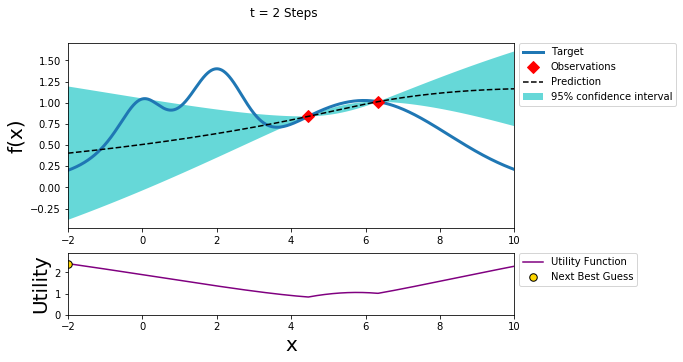

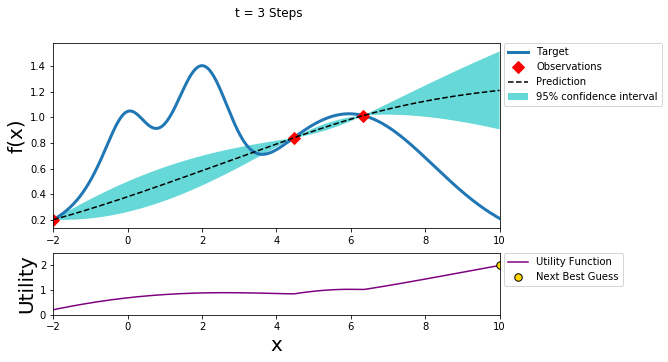

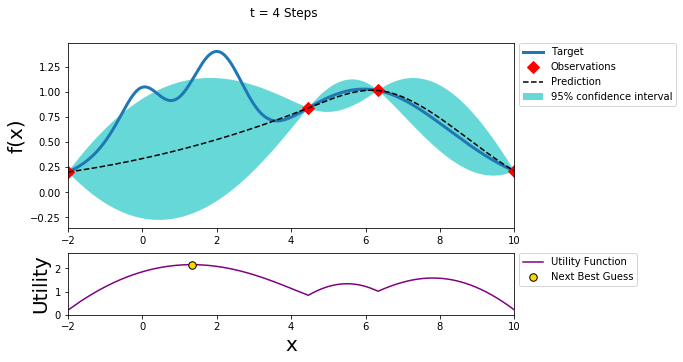

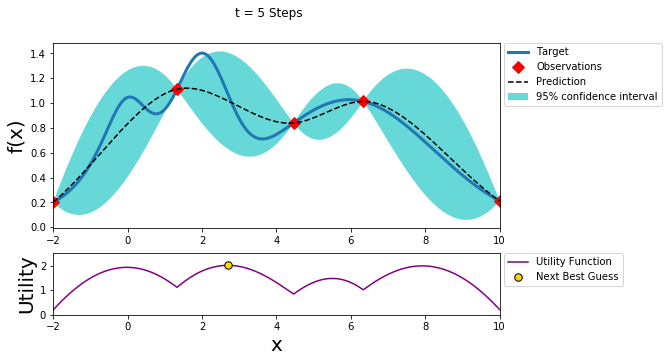

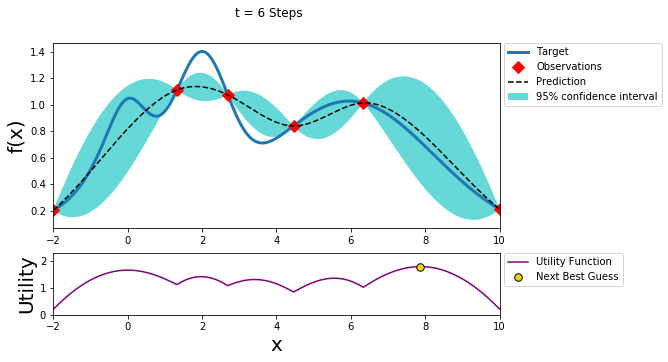

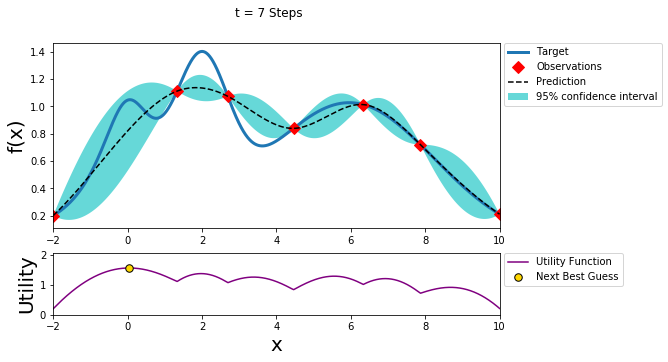

In [37]:
for t in range(1,7):
    bo.maximize(init_points=0, n_iter=1, kappa=5)
    plot_gp(bo, x, y)

## Stopping

This procedure is repeated after a pre-specified number of iterations or after a convergance criteria has been met. Note, that after just sampling only seven points the algorithm was able to get pretty close to the true maximum x=2).

It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure.

## 3. Optimizing Hyperparameters Example


Here we use Bayesian Optimization to find the best parameters for a Support Vector Machine and for a Random Forest Classifier.

The example below is adapted from [here](https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py).



In [6]:
from __future__ import print_function
from __future__ import division

from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

# Load data set and target values
data, target = make_classification(
    n_samples=1000,
    n_features=45,
    n_informative=12,
    n_redundant=7
)

def svccv(C, gamma):
    val = cross_val_score(
        SVC(C=C, gamma=gamma, random_state=2),
        data, target, 'f1', cv=2
    ).mean()

    return val

def rfccv(n_estimators, min_samples_split, max_features):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=2
        ),
        data, target, 'f1', cv=2
    ).mean()
    return val

if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    svcBO = BayesianOptimization(svccv,
        {'C': (0.001, 100), 'gamma': (0.0001, 0.1)})
    svcBO.explore({'C': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01, 0.1]})

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (10, 250),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 0.999)}
    )

    svcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    rfcBO.maximize(n_iter=10, **gp_params)
    

    print('-' * 53)
    print('Final Results')
    print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    1 | 00m00s |    0.00000 |    0.0010 |    0.0010 | 
    2 | 00m00s |    0.00000 |    0.0100 |    0.0100 | 


/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/metric

    3 | 00m00s |    0.00000 |    0.1000 |    0.1000 | 
    4 | 00m00s |    0.92977 |   53.8068 |    0.0191 | 
    5 | 00m00s |    0.88139 |   26.6839 |    0.0523 | 
    6 | 00m00s |    0.51299 |   31.4426 |    0.0818 | 
    7 | 00m00s |    0.88139 |   38.5870 |    0.0508 | 
    8 | 00m00s |    0.88219 |   69.5046 |    0.0466 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         C |     gamma | 
    9 | 00m05s |    0.87216 |   97.8811 |    0.0001 | 
   10 | 00m02s |    0.14751 |   84.1110 |    0.1000 | 
   11 | 00m02s |    0.87090 |   16.2515 |    0.0001 | 
   12 | 00m02s |    0.87680 |   46.1075 |    0.0001 | 
   13 | 00m02s |    0.14751 |   61.9169 |    0.1000 | 
   14 | 00m02s |    0.86927 |   75.0820 |    0.0001 | 


/Users/Home/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.13359996e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   15 | 00m01s |    0.14751 |   21.4244 |    0.1000 | 
   16 | 00m02s |    0.87298 |    9.9642 |    0.0001 | 
   17 | 00m02s |    0.14751 |   92.4634 |    0.1000 | 
   18 | 00m01s |    0.14751 |   50.1906 |    0.1000 | 
-----------------------------------------------------
Initialization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   min_samples_split |   n_estimators | 
    1 | 00m00s |    0.87537 |         0.5063 |             22.5421 |        51.1506 | 
    2 | 00m00s |    0.87429 |         0.4144 |             24.3161 |        49.3652 | 
    3 | 00m01s |    0.88587 |         0.4359 |              2.1423 |       122.6744 | 
    4 | 00m01s |    0.89017 |         0.4008 |             13.4833 |       142.3388 | 
    5 | 00m00s |    0.88142 |         0.5169 |              9.9340 |        62.8582 | 
Bayesian Optimization
---------------------------------------------------------------------------------